In [1]:
import os
import warnings
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision

from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
import json
import re

from utils import test_model, compare_models_prediction, generate_z_samples
from zoo_utils import load_hyperrep_edx

from shrp.models.def_net import CNN, CNN3
from shrp.models.def_AE_trainable import get_transformations
from shrp.datasets.dataset_auxiliaries import tokens_to_recipe, tokens_to_checkpoint
from shrp.models.def_loss import DistillationLoss, ReconDistillationLoss

/netscratch2/lmeynent/research/structure_vs_behaviour/zoo_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid',
              rc={
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'xtick.bottom': True,
                  'ytick.left': True,
                  'font.family': 'Fira Sans'
              })

COLOURS = [
    '#960018',  # Carmine Red
    '#FED85D',  # Mustard Gold
    '#434384',  # Marian Blue
    '#54B674',  # Emerald Green
    '#D183C9',  # French Mauve
    '#318CE7',  # French Blue
    '#D08000'   # Fulvous Orange
]

## Loading data

In [4]:
DATASETS = ['svhn', 'cifar10', 'eurosat']
DATASET_LABELS = {
    'svhn': 'SVHN',
    'cifar10': 'CIFAR-10',
    'eurosat': 'EuroSAT'
}

DS_ORDER = ['SVHN', 'CIFAR-10', 'EuroSAT']
HR_ORDER = ['Contrastive + Structure (Baseline)', 'Behavior', 'Contrastive + Behavior', 'Structure + Behavior', 'Contrastive + Structure + Behavior']
HR_PLOT = ['Contrastive + Structure (Baseline)', 'Contrastive + Behavior', 'Contrastive + Structure + Behavior']

HYPERREP_PATH = Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/hyperrepresentations/tune')

EXPERIMENT_PATH = Path.cwd() / 'results' 

In [5]:
MAX_EPOCH = 100

df_hr = pd.DataFrame(columns=[
    'Model zoo',
    'Trial ID',
    'Learning rate',
    'Latent dimension',
    'Behaviour loss',
    'Query set',
    'Query dataset',
    '# of queries',
    'Gamma',
    'Beta',
    'Epoch',
    'Train loss',
    'Train loss (contrast)', 
    'Train loss (recon)',
    'Train loss (structure)', 
    'Train loss (behaviour)',
    'Test loss',
    'Test loss (contrast)', 
    'Test loss (recon)',
    'Test loss (structure)', 
    'Test loss (behaviour)',
    'Dstk: Test accuracy',
    'Dstk: GGap'
])

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    hr_path = HYPERREP_PATH / f"{ds}_train_hyperrep"
    for path in os.listdir(hr_path):
        if not re.match('AE_trainable', path):
            continue
        path = hr_path / path

        with open(path / 'params.json') as ifh_config, open(path / 'result.json') as ifh_result:
            config = json.load(ifh_config)
            result = pd.read_json(ifh_result, lines=True, dtype={'trial_id': str})

        for edx in range(len(result)):
            df_hr.loc[len(df_hr)] = (
                DATASET_LABELS[ds],
                result.loc[edx]['trial_id'],
                config['optim::lr'],
                config['ae:lat_dim'],
                config['training::loss_distillation'],
                config['training::queryset_distillation'],
                config['training::queryset_dump'],
                config['training::n_queries_distillation'],
                config['training::gamma'],
                config['training::beta'],
                result.loc[edx]['training_iteration'],
                result.loc[edx]['loss/loss_train'],
                result.loc[edx]['loss/loss_contrast_train'],
                result.loc[edx]['loss/loss_recon_train'],
                result.loc[edx]['loss/loss_structure_train'],
                result.loc[edx]['loss/loss_behaviour_train'],
                result.loc[edx]['loss/loss_test'],
                result.loc[edx]['loss/loss_contrast_test'],
                result.loc[edx]['loss/loss_recon_test'],
                result.loc[edx]['loss/loss_structure_test'],
                result.loc[edx]['loss/loss_behaviour_test'],
                result.loc[edx]['dstk/test_acc_test'],
                result.loc[edx]['dstk/ggap_test']
            )

df_hr['Query dataset'] = df_hr['Query dataset'].map({
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/svhn_train_zoo_relu/dataset.pt': 'SVHN',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_relu/dataset.pt': 'CIFAR-10',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/eurosat_train_zoo_relu/dataset.pt': 'EuroSAT',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/tinyimagenet_32/dataset.pt': 'TinyImagenet-32'
})
df_hr.head()

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

,Model zoo,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
0,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,1.344194,0.930796,1.390127,1.059503,1.045855,1.060222,0.791913,1.090034,0.559680,0.283559
1,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.275532,0.770928,0.220488,0.257198,0.887651,0.224016,0.591360,0.183200,0.554503,0.276677
2,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.266038,0.677502,0.220320,0.247892,0.708432,0.223653,0.544859,0.187963,0.550643,0.276275
3,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.264123,0.664841,0.219599,0.239949,0.652948,0.218212,0.527920,0.183800,0.551713,0.279411
4,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.261248,0.628665,0.220424,0.242219,0.741064,0.215964,0.495595,0.184894,0.538348,0.282729


In [6]:
idx_dict = {
    '00011': 'Contrastive + Structure (Baseline)',
    '00000': 'Behavior',
    '00006': 'Contrastive + Behavior',
    '00002': 'Structure + Behavior',
    '00008': 'Contrastive + Structure + Behavior'
}

df_hr['Hyper-representation'] = df_hr['Trial ID'].str.slice(start=-5).map(idx_dict)

### Loading model zoos metadata

In [7]:
DF_ZOO_PATH = EXPERIMENT_PATH / 'zoo_analysis' / 'df_zoo.csv'

df_zoo = pd.read_csv(DF_ZOO_PATH, index_col=0)
df_zoo.head()

,Model zoo,Trial ID,Activation function,Initialisation,Learning rate,Weight decay,Seed,Epoch,Test accuracy,Generalisation gap
0,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,0,0.071758,-0.001563
1,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,1,0.775200,-0.182034
2,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,2,0.829479,-0.016614
3,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,3,0.846381,-0.003682
4,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,4,0.848033,0.010410


### Loading reconstruction accuracies

In [8]:
zoo_acc = list()

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    df_zoo_acc_path = EXPERIMENT_PATH / f'hr_analysis_{ds}' / 'df_zoo_acc.csv'
    df_zoo_acc = pd.read_csv(df_zoo_acc_path, index_col=0)
    
    df_zoo_acc['Model zoo'] = DATASET_LABELS[ds]
    
    zoo_acc.append(df_zoo_acc)
    
zoo_acc = pd.concat(zoo_acc)
zoo_acc.head()

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

,Model index,Hyper-representation model,Original accuracy,Reconstruction accuracy,Model zoo
0,0,Contrastive + Structure (Baseline),0.743623,0.195874,SVHN
1,1,Contrastive + Structure (Baseline),0.828596,0.195913,SVHN
2,2,Contrastive + Structure (Baseline),0.856215,0.295444,SVHN
3,3,Contrastive + Structure (Baseline),0.873848,0.429779,SVHN
4,4,Contrastive + Structure (Baseline),0.887792,0.581400,SVHN


### Loading generation accuracies

In [9]:
gen_acc = list()

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    df_gen_acc_path = EXPERIMENT_PATH / f'hr_analysis_{ds}' / 'df_generative.csv'
    df_gen_acc = pd.read_csv(df_gen_acc_path, index_col=0)
    
    df_gen_acc['Model zoo'] = DATASET_LABELS[ds]
    
    gen_acc.append(df_gen_acc)
    
gen_acc = pd.concat(gen_acc)
gen_acc.head()

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

,Hyper-representation model,Origin,Accuracy,Model zoo
0,Contrastive + Structure (Baseline),Generated,0.369084,SVHN
1,Contrastive + Structure (Baseline),Generated,0.159381,SVHN
2,Contrastive + Structure (Baseline),Generated,0.221996,SVHN
3,Contrastive + Structure (Baseline),Generated,0.288222,SVHN
4,Contrastive + Structure (Baseline),Generated,0.195874,SVHN


### Loading generation diversity

In [10]:
gen_diversity = dict()

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    gen_diversity_path = EXPERIMENT_PATH / f'hr_analysis_{ds}' / 'gen_diversity.json'
    with open(gen_diversity_path, 'r') as ifh:
        gen_diversity[ds] = json.load(ifh)

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

## Analysing data

### Plotting figures

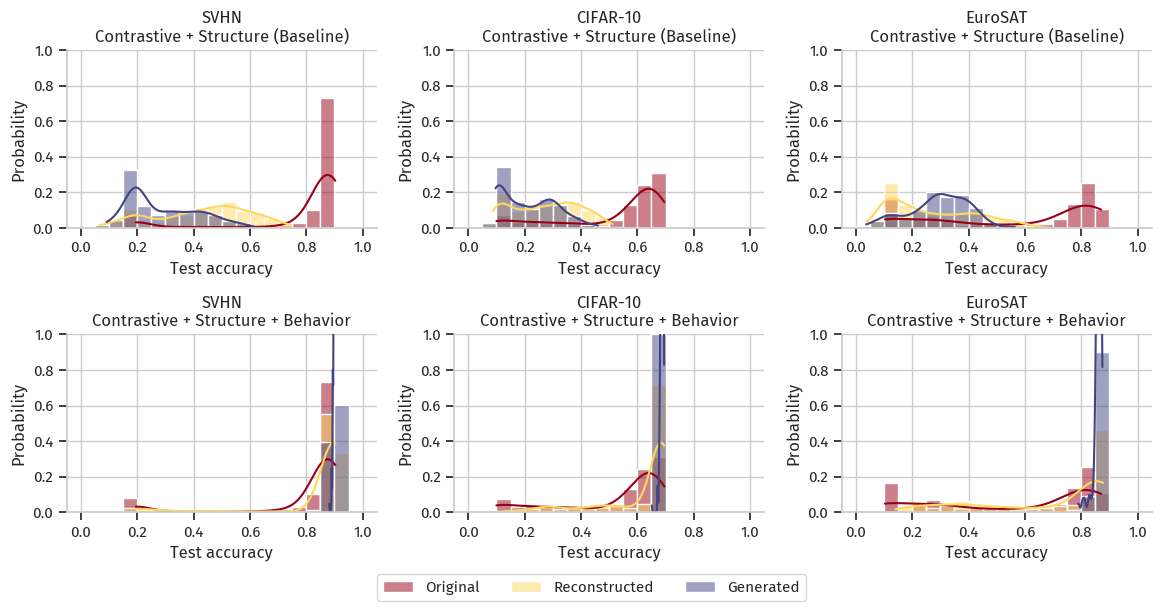

In [11]:
_, axs = plt.subplots(2, 3, figsize=(14, 6))

for d, ds in enumerate(DATASETS):
    ds_label = DATASET_LABELS[ds]
    df_zoo_acc = zoo_acc[zoo_acc['Model zoo'] == ds_label]
    df_generative = gen_acc[gen_acc['Model zoo'] == ds_label]

    label = 'Contrastive + Structure (Baseline)'
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[0][d])
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstructed', ax=axs[0][d])
    sns.histplot(
        df_generative[(df_generative['Hyper-representation model'] == label) & (df_generative['Origin'] == 'Generated')],
        x='Accuracy',
        stat='probability',
        binwidth=0.05,
        binrange=(0., 1.),
        kde=True,
        color=COLOURS[2],
        alpha=0.5,
        label='Generated',
        ax=axs[0][d]
    )
    axs[0][d].set(title=f"{ds_label}\n{label}", xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    
    label = 'Contrastive + Structure + Behavior'
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[1][d])
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstructed', ax=axs[1][d])
    sns.histplot(
        df_generative[(df_generative['Hyper-representation model'] == label) & (df_generative['Origin'] == 'Generated')],
        x='Accuracy',
        stat='probability',
        binwidth=0.05,
        binrange=(0., 1.),
        kde=True,
        color=COLOURS[2],
        alpha=0.5,
        label='Generated',
        ax=axs[1][d]
    )
    axs[1][d].set(title=f"{ds_label}\n{label}", xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    
plt.legend(loc=(-1.50, -0.50), ncols=3)
plt.subplots_adjust(hspace=0.6, wspace=0.25)
plt.savefig('figures/generative_dstk.png', dpi=300, bbox_inches='tight')
plt.show()

### Analysing generated models' diversity

#### Structure

In [12]:
df_div_str = pd.DataFrame(columns=['Losses', 'Model zoo', 'Average', 'Standard deviation'])

for ds, data in gen_diversity.items():
    for hr, dist in data.items():
        df_div_str.loc[len(df_div_str)] = (hr, DATASET_LABELS[ds], np.mean(dist['l2_structure']), np.std(dist['l2_structure']))
        
df_div_str['print'] = df_div_str['Average'].map(lambda x: f"{x:.1f}") + df_div_str['Standard deviation'].map(lambda x: f" (±{x:.0f})")
df_div_str = df_div_str.pivot(index='Losses', columns='Model zoo', values='print')
df_div_str = df_div_str.loc[['Model zoo'] + HR_ORDER, DS_ORDER]
df_div_str = df_div_str.style.format(precision=3)
print(df_div_str.to_latex())
df_div_str

\begin{tabular}{llll}
Model zoo & SVHN & CIFAR-10 & EuroSAT \\
Losses &  &  &  \\
Model zoo & 23.3 (±4) & 22.9 (±4) & 23.0 (±5) \\
Contrastive + Structure (Baseline) & 13.4 (±3) & 14.9 (±4) & 16.8 (±5) \\
Behavior & 1.6 (±0) & 3.5 (±1) & 6.3 (±1) \\
Contrastive + Behavior & 1.7 (±0) & 1.5 (±0) & 3.0 (±1) \\
Structure + Behavior & 1.6 (±0) & 1.5 (±0) & 2.8 (±1) \\
Contrastive + Structure + Behavior & 1.5 (±0) & 1.3 (±0) & 2.1 (±1) \\
\end{tabular}



Model zoo,SVHN,CIFAR-10,EuroSAT
Losses,,,
Model zoo,23.3 (±4),22.9 (±4),23.0 (±5)
Contrastive + Structure (Baseline),13.4 (±3),14.9 (±4),16.8 (±5)
Behavior,1.6 (±0),3.5 (±1),6.3 (±1)
Contrastive + Behavior,1.7 (±0),1.5 (±0),3.0 (±1)
Structure + Behavior,1.6 (±0),1.5 (±0),2.8 (±1)
Contrastive + Structure + Behavior,1.5 (±0),1.3 (±0),2.1 (±1)


#### Behavior

In [ ]:
df_div_str = pd.DataFrame(columns=['Losses', 'Model zoo', 'Average', 'Standard deviation'])

for ds, data in gen_diversity.items():
    for hr, dist in data.items():
        df_div_str.loc[len(df_div_str)] = (hr, DATASET_LABELS[ds], np.mean(dist['l2_behaviour']), np.std(dist['l2_behaviour']))
        
df_div_str['print'] = df_div_str['Average'].map(lambda x: f"{x:.1f}") + df_div_str['Standard deviation'].map(lambda x: f" (±{x:.0f})")
df_div_str = df_div_str.pivot(index='Losses', columns='Model zoo', values='print')
df_div_str = df_div_str.loc[['Model zoo'] + HR_ORDER, DS_ORDER]
df_div_str = df_div_str.style.format(precision=3)
print(df_div_str.to_latex())
df_div_str

### Examining the maximum performance of models

In [21]:
max_acc = zoo_acc.groupby(['Model zoo', 'Hyper-representation model'])[['Original accuracy', 'Reconstruction accuracy']].max()

# Adding max performance data for the entire zoo
max_acc['Zoo accuracy'] = max_acc.index.get_level_values('Model zoo').map(df_zoo.groupby(['Model zoo'])['Test accuracy'].max().to_dict())

# This data corresponds to the test split of the model zoo only
max_acc['Test split accuracy'] = max_acc['Original accuracy']
max_acc = max_acc.drop('Original accuracy', axis=1)

# Adding max performance data for generated models
max_acc['Generation accuracy'] = gen_acc.groupby(['Model zoo', 'Hyper-representation model'])['Accuracy'].max()

# Computing max performance difference between reconstructed / generated models and the entire zoo
max_acc['$\Delta_{Acc}$ Reconstruction'] = max_acc['Reconstruction accuracy'] - max_acc['Zoo accuracy']
max_acc['$\Delta_{Acc}$ Generation'] = max_acc['Generation accuracy'] - max_acc['Zoo accuracy']

# Re-ordering lines
new_index = pd.MultiIndex.from_product([DS_ORDER, ['Contrastive + Structure (Baseline)', 'Contrastive + Structure + Behavior']], names=['Model zoo', 'Hyper-representation model'])
max_acc = max_acc.reindex(new_index).loc[:, ['Zoo accuracy', 'Reconstruction accuracy', '$\Delta_{Acc}$ Reconstruction', 'Generation accuracy', '$\Delta_{Acc}$ Generation']]

# Print
max_acc = max_acc.style.format('{:.1%}')
print(max_acc.to_latex())
max_acc

\begin{tabular}{llrrrrr}
 &  & Zoo accuracy & Reconstruction accuracy & $\Delta_{Acc}$ Reconstruction & Generation accuracy & $\Delta_{Acc}$ Generation \\
Model zoo & Hyper-representation model &  &  &  &  &  \\
\multirow[c]{2}{*}{SVHN} & Contrastive + Structure (Baseline) & 91.0% & 74.5% & -16.5% & 61.3% & -29.7% \\
 & Contrastive + Structure + Behavior & 91.0% & 90.4% & -0.6% & 90.4% & -0.6% \\
\multirow[c]{2}{*}{CIFAR-10} & Contrastive + Structure (Baseline) & 70.1% & 51.2% & -18.9% & 46.0% & -24.1% \\
 & Contrastive + Structure + Behavior & 70.1% & 69.5% & -0.6% & 69.5% & -0.6% \\
\multirow[c]{2}{*}{EuroSAT} & Contrastive + Structure (Baseline) & 88.5% & 68.6% & -19.9% & 56.5% & -32.0% \\
 & Contrastive + Structure + Behavior & 88.5% & 87.7% & -0.8% & 87.5% & -1.0% \\
\end{tabular}

